# Práctica 3: Estructura de las perturbaciones transitorias

In [17]:
import numpy as np
import netCDF4 as nc
from scipy import stats
from scipy import signal
from scipy.fft import fft, ifft, fftfreq
import matplotlib as mpl
import matplotlib.pyplot as plt
from scipy.stats.stats import pearsonr
import cartopy.crs as ccrs
from cartopy.util import add_cyclic_point
import numpy.ma as ma
import numpy.linalg as linalg
import time

C:\Users\ideapad 5 15ITL05\AppData\Local\Temp\ipykernel_17332\548072590.py:8: DeprecationWarning: Please use `pearsonr` from the `scipy.stats` namespace, the `scipy.stats.stats` namespace is deprecated.
  from scipy.stats.stats import pearsonr


En esta práctica analizaremos en detalle la estructura típica de las perturbaciones transitorias usando técnicas de regresión. Investigaremos cómo se inclinan las perturbaciones en latitud y altura, así como la relación espacial entre unas variables y otras. De forma consistente con la teoría, esta estructura da lugar a transportes eddy de calor y momento, lo cuales se asocian asimismo a crecimiento o declive de las perturbaciones. Para el informe de la práctica tenéis que comentar los resultados tomando como guía las preguntas de este guión.

### 1. Estructura de la variabilidad en capas altas

Calcular el mapa de regresión, en función de longitud y latitud, de las anomalías diarias de velocidad meridiana a 300 hPa durante el invierno boreal extendido (Noviembre a Marzo) con las anomalías estandarizadas de dicha variable en un punto situado frente a la costa de Nova Scotia, con coordenadas 55W, 45N, 300hPa. 

   a) Representar en paneles sucesivos la evolución de dicho mapa para desfases de -2, -1, 0, +1 y +2 días, superponiendo el mapa de costas. 
   
##### ¿Puedes apreciar la estructura de paquete de ondas? ¿Cómo se inclinan las líneas de fase en dirección meridiana, y cuáles son las implicaciones? 
    
   b) Repetir el proceso con la envolvente del paquete de ondas de la velocidad meridiana. 
   
##### ¿Es esta figura consistente con la obtenida en el apartado anterior? 
    
   c) Representar en un diagrama de Hovmoeller la regresión de la velocidad meridiana con su valor en el punto base en función de longitud (eje x) y desfase (eje y) para latitud y presión fijas (45N, 300hPa) y desfases comprendidos entre -7 y +7 días. 

##### ¿Puedes estimar las velocidades de fase y de grupo a partir de este diagrama?  

(a) Represento el mapa de regresión para los desfases desde -2 a +2 días

In [18]:
#indica el path donde tienes los datos
fname ='datosinv19-20.nc'
fil = nc.Dataset(fname)
allvars = fil.variables
allvars

{'t': <class 'netCDF4._netCDF4.Variable'>
 float32 t(time, level, lat, lon)
     long_name: daily mean 6-hourly Air Temperature on Pressure Levels
     units: degK
     precision: 2
     least_significant_digit: 1
     GRIB_id: 11
     GRIB_name: TMP
     var_desc: Air temperature
     dataset: NCEP/DOE AMIP-II Reanalysis (Reanalysis-2) Daily Averages
     level_desc: Pressure Levels
     statistic: Mean
     parent_stat: Individual Obs
     standard_name: air_temperature
     missing_value: -9.96921e+36
     actual_range: [178.53 318.74]
     valid_range: [137.5 362.5]
 unlimited dimensions: time
 current shape = (152, 14, 21, 144)
 filling on, default _FillValue of 9.969209968386869e+36 used,
 'lat': <class 'netCDF4._netCDF4.Variable'>
 float32 lat(lat)
     units: degrees_north
     long_name: Latitude
     standard_name: latitude
     axis: Y
     coordinate_defines: point
     actual_range: [ 90. -90.]
 unlimited dimensions: 
 current shape = (21,)
 filling on, default _FillValue 

In [19]:
# Abrir variable v y dimensiones
lon= fil.variables['lon'][:]
lat= fil.variables['lat'][:]
time= fil.variables['time'][:]
levels= fil.variables['level'][:]
V= fil.variables['v'][:]

nt,nlev,nlat,nlon= V.shape
import xarray as xr
file= xr.open_dataset(fname)

file

<xarray.Dataset>
Dimensions:    (time: 152, level: 14, lat: 21, lon: 144, nbnds: 2)
Coordinates:
  * lat        (lat) float32 70.0 67.5 65.0 62.5 60.0 ... 27.5 25.0 22.5 20.0
  * level      (level) float32 1e+03 925.0 850.0 700.0 ... 150.0 100.0 70.0 50.0
  * lon        (lon) float32 0.0 2.5 5.0 7.5 10.0 ... 350.0 352.5 355.0 357.5
  * time       (time) datetime64[ns] 2019-11-01 2019-11-02 ... 2020-03-31
Dimensions without coordinates: nbnds
Data variables:
    t          (time, level, lat, lon) float32 ...
    time_bnds  (time, nbnds) datetime64[ns] ...
    u          (time, level, lat, lon) float32 ...
    v          (time, level, lat, lon) float32 ...
    w          (time, level, lat, lon) float32 ...
    z          (time, level, lat, lon) float32 ...
Attributes:
    Conventions:    CF-1.0
    title:          mean daily NCEP/DOE Reanalysis 2
    comments:       Data is from \nNCEP/DOE AMIP-II Reanalysis (Reanalysis-2)...
    platform:       Model
    source:         NCEP/DOE AMIP-II Reanalysis (Reanalysis-2) Model
    institution:    National Centers for Environmental Prediction
    dataset_title:  NCEP-DOE AMIP-II Reanalysis
    References:     https://www.psl.noaa.gov/data/gridded/data.ncep.reanalysi...
    source_url:     http://www.cpc.ncep.noaa.gov/products/wesley/reanalysis2/
    NCO:            netCDF Operators version 4.9.1 (Homepage = http://nco.sf....
    history:        Sat Mar 20 08:21:03 2021: ncrcat -O -d lat,20.000000,70.0...

In [20]:
# Encontrar el punto con coordenadas 55W, 45N, 300hPa
punto= file.sel(lon=360-55, lat=45, level=300)
# seleccionar el punto en cuestión en v (serie de referencia)
punto_v_ref= punto.v
# calcular las anomalías estarndarizadas de la serie de referencia
punto_v_ref_std= (punto_v_ref-punto_v_ref.mean())/punto_v_ref.std()
#Vpa = np.expand_dims(Vpa, axis=-1) # Add an extra dimension in the last axis.

In [21]:
# Definir v en el nivel de 300 hPa
ns= nlat*nlon
Vlev= file.sel(level=300).v
Vlev_2d= np.transpose(np.reshape(np.array(Vlev),(nt,ns)))
Vlev_2d= Vlev_2d-Vlev_2d.mean(axis=0)
Vlev_2d.shape


(3024, 152)

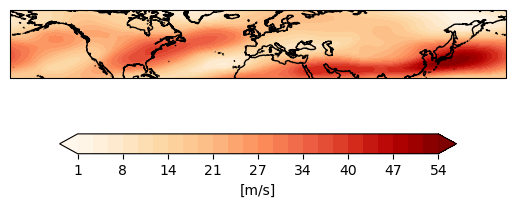

In [31]:
fig= plt.figure(111)
ax= fig.add_subplot(1,1,1, projection=ccrs.PlateCarree())
ax.coastlines()
creg, clon = add_cyclic_point(file.sel(level=300).u.mean(dim='time'), coord=lon)
levels= np.round(np.linspace(np.min(creg),np.max(creg),num=25),decimals=0)
im= ax.contourf(clon,lat,creg,levels=levels,cmap='OrRd',extend='both',transform= ccrs.PlateCarree())
plt.colorbar(im, ax=ax,label='[m/s]',orientation='horizontal',shrink=0.8)

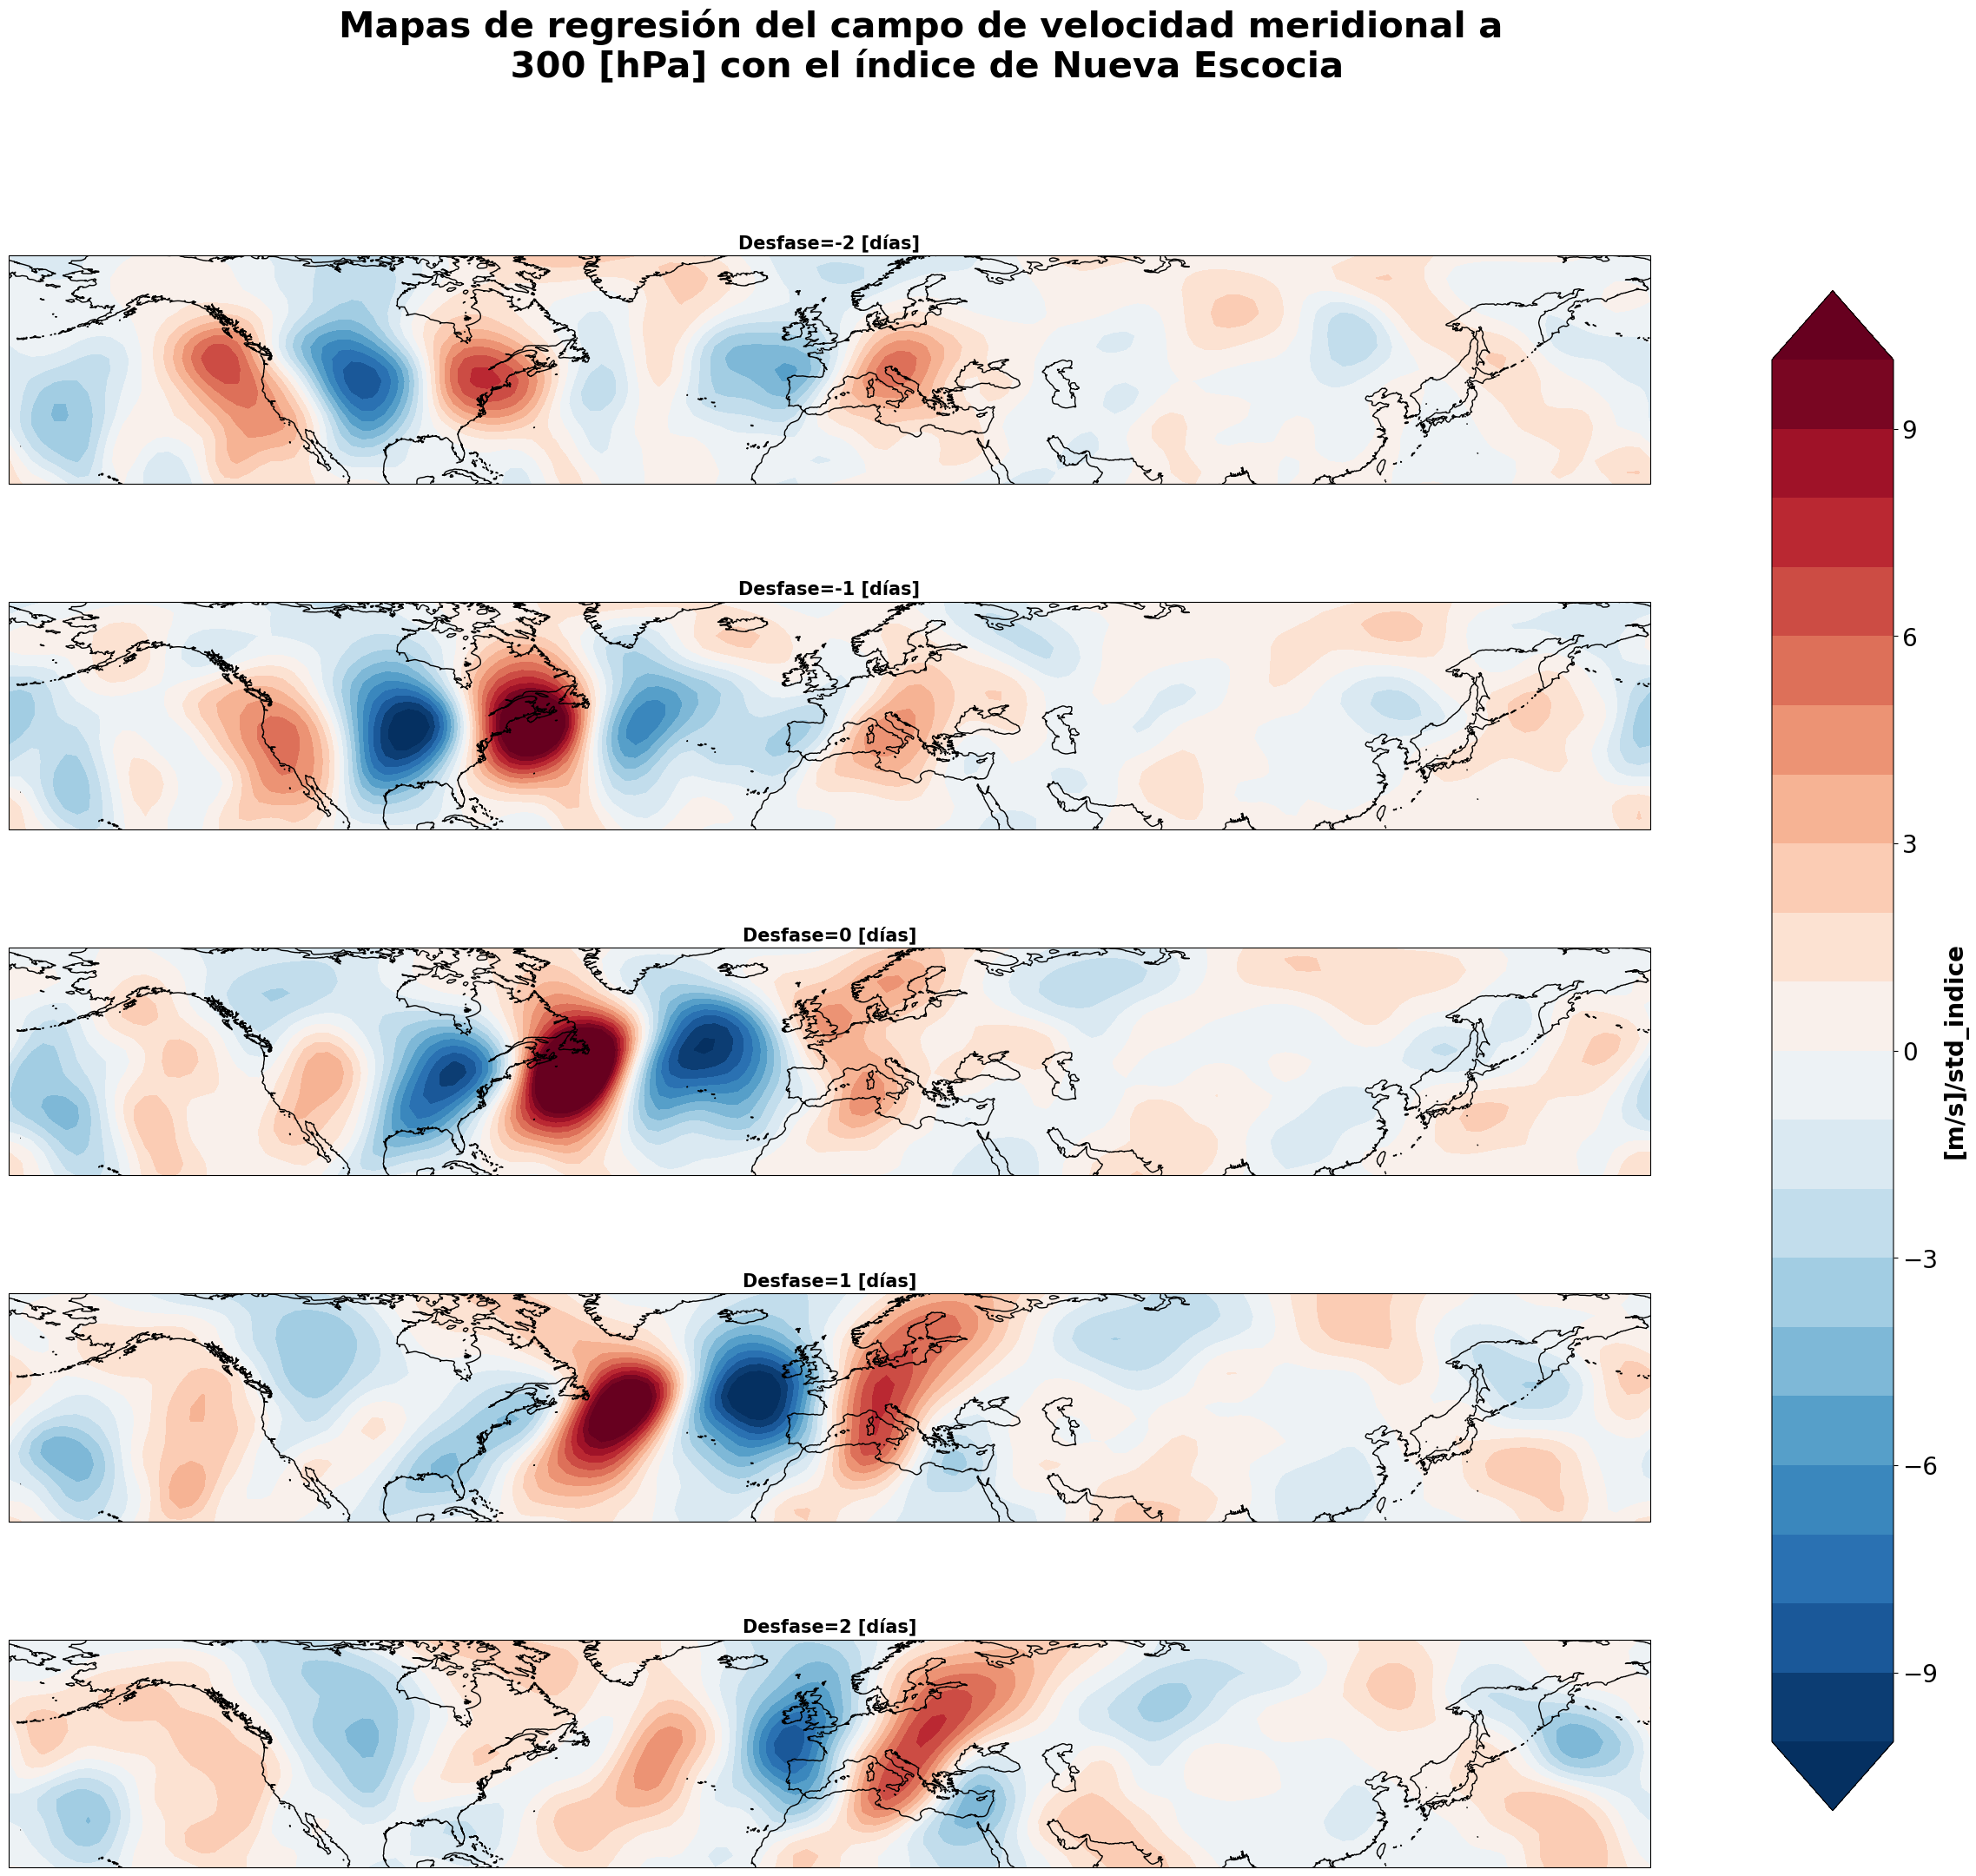

In [7]:
# definir un vector con los desfases temporales (lags)
lags= np.arange(-2,3,1)
# Regresión con desfases
fig= plt.figure(515,figsize=(28,25))
s=0
for l in lags: 
    # definir los límites del intervalo temporal (al hacer desfases no se pueden tomar todos los puntos de la serie)
    nmin=0-np.min([l,0])
    nmax=nt-np.max([l,0])-1
    npoints=nmax-nmin+1;   
    # calcular la regresión de la serie de anomalías estandarizadas sobre el campo
    reg=np.dot(Vlev_2d[:,nmin+l:nmax+l],punto_v_ref_std[nmin:nmax])
    reg=reg/npoints
    reg=np.reshape(reg,(nlat,nlon))
    
    # pintar figura para cada desfase
    # Necesario para que pinte bien en lon=0
    creg, clon = add_cyclic_point(reg, coord=lon)
    s+=1
    ax= fig.add_subplot(5,1,s, projection=ccrs.PlateCarree())
    clevs= np.arange(-10,11,1)
    im= ax.contourf(clon,lat,creg,clevs,cmap='RdBu_r',extend='both',transform= ccrs.PlateCarree())
    ax.coastlines()
    #fig.colorbar(im,ax=ax,label='[m/s]/std_indice')
    ax.set_title(label='Desfase=%i [días]' %(l),fontsize=15,weight='bold')

fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
colorbar = plt.colorbar(im, cax=cbar_ax,label='[m/s]/std_indice')
colorbar.ax.tick_params(labelsize=20)
colorbar.ax.set_ylabel('[m/s]/std_indice', fontsize=20,weight='bold')
fig.suptitle('Mapas de regresión del campo de velocidad meridional a\n 300 [hPa] con el índice de Nueva Escocia',fontsize=30,weight='bold')
#plt.tight_layout()
plt.savefig('Parte 1/regresion_con_v.png')

(b) Represento la envolvente de las perturbaciones

In [8]:
Vlev.shape

(152, 21, 144)

In [9]:
# Calculo la envolvente: amplitud de las ondas. 
Vlev= Vlev_2d #aquí cogerla sin estandarizar creo
Vlev=np.reshape(Vlev,(nlat,nlon,nt))
yf=fft(Vlev,axis=1)
xf = fftfreq(nlon,1)[:(nlon)//2]
# Selecciono las componentes con número de onda zonal entre 4 y 9.
yf[:,0:3,:]=0
yf[:,9:-1,:]=0
Vf=2*abs(ifft(yf,axis=1))
# Selecciono el punto de referencia en el campo de amplitudes
py= np.where(lat==45)
px= np.where(lon==360-55)
Vfp=np.squeeze(Vf[py,px,:])
# Obtengo la serie de referencia (anomalías estandarizadas)
Vfpa=np.squeeze((Vfp-np.mean(Vfp,axis=0))/np.std(Vfp,axis=0))
Vfpa= np.squeeze((Vfp))
Vf=Vf.reshape((ns,nt))
np.shape(Vfpa)

(152,)

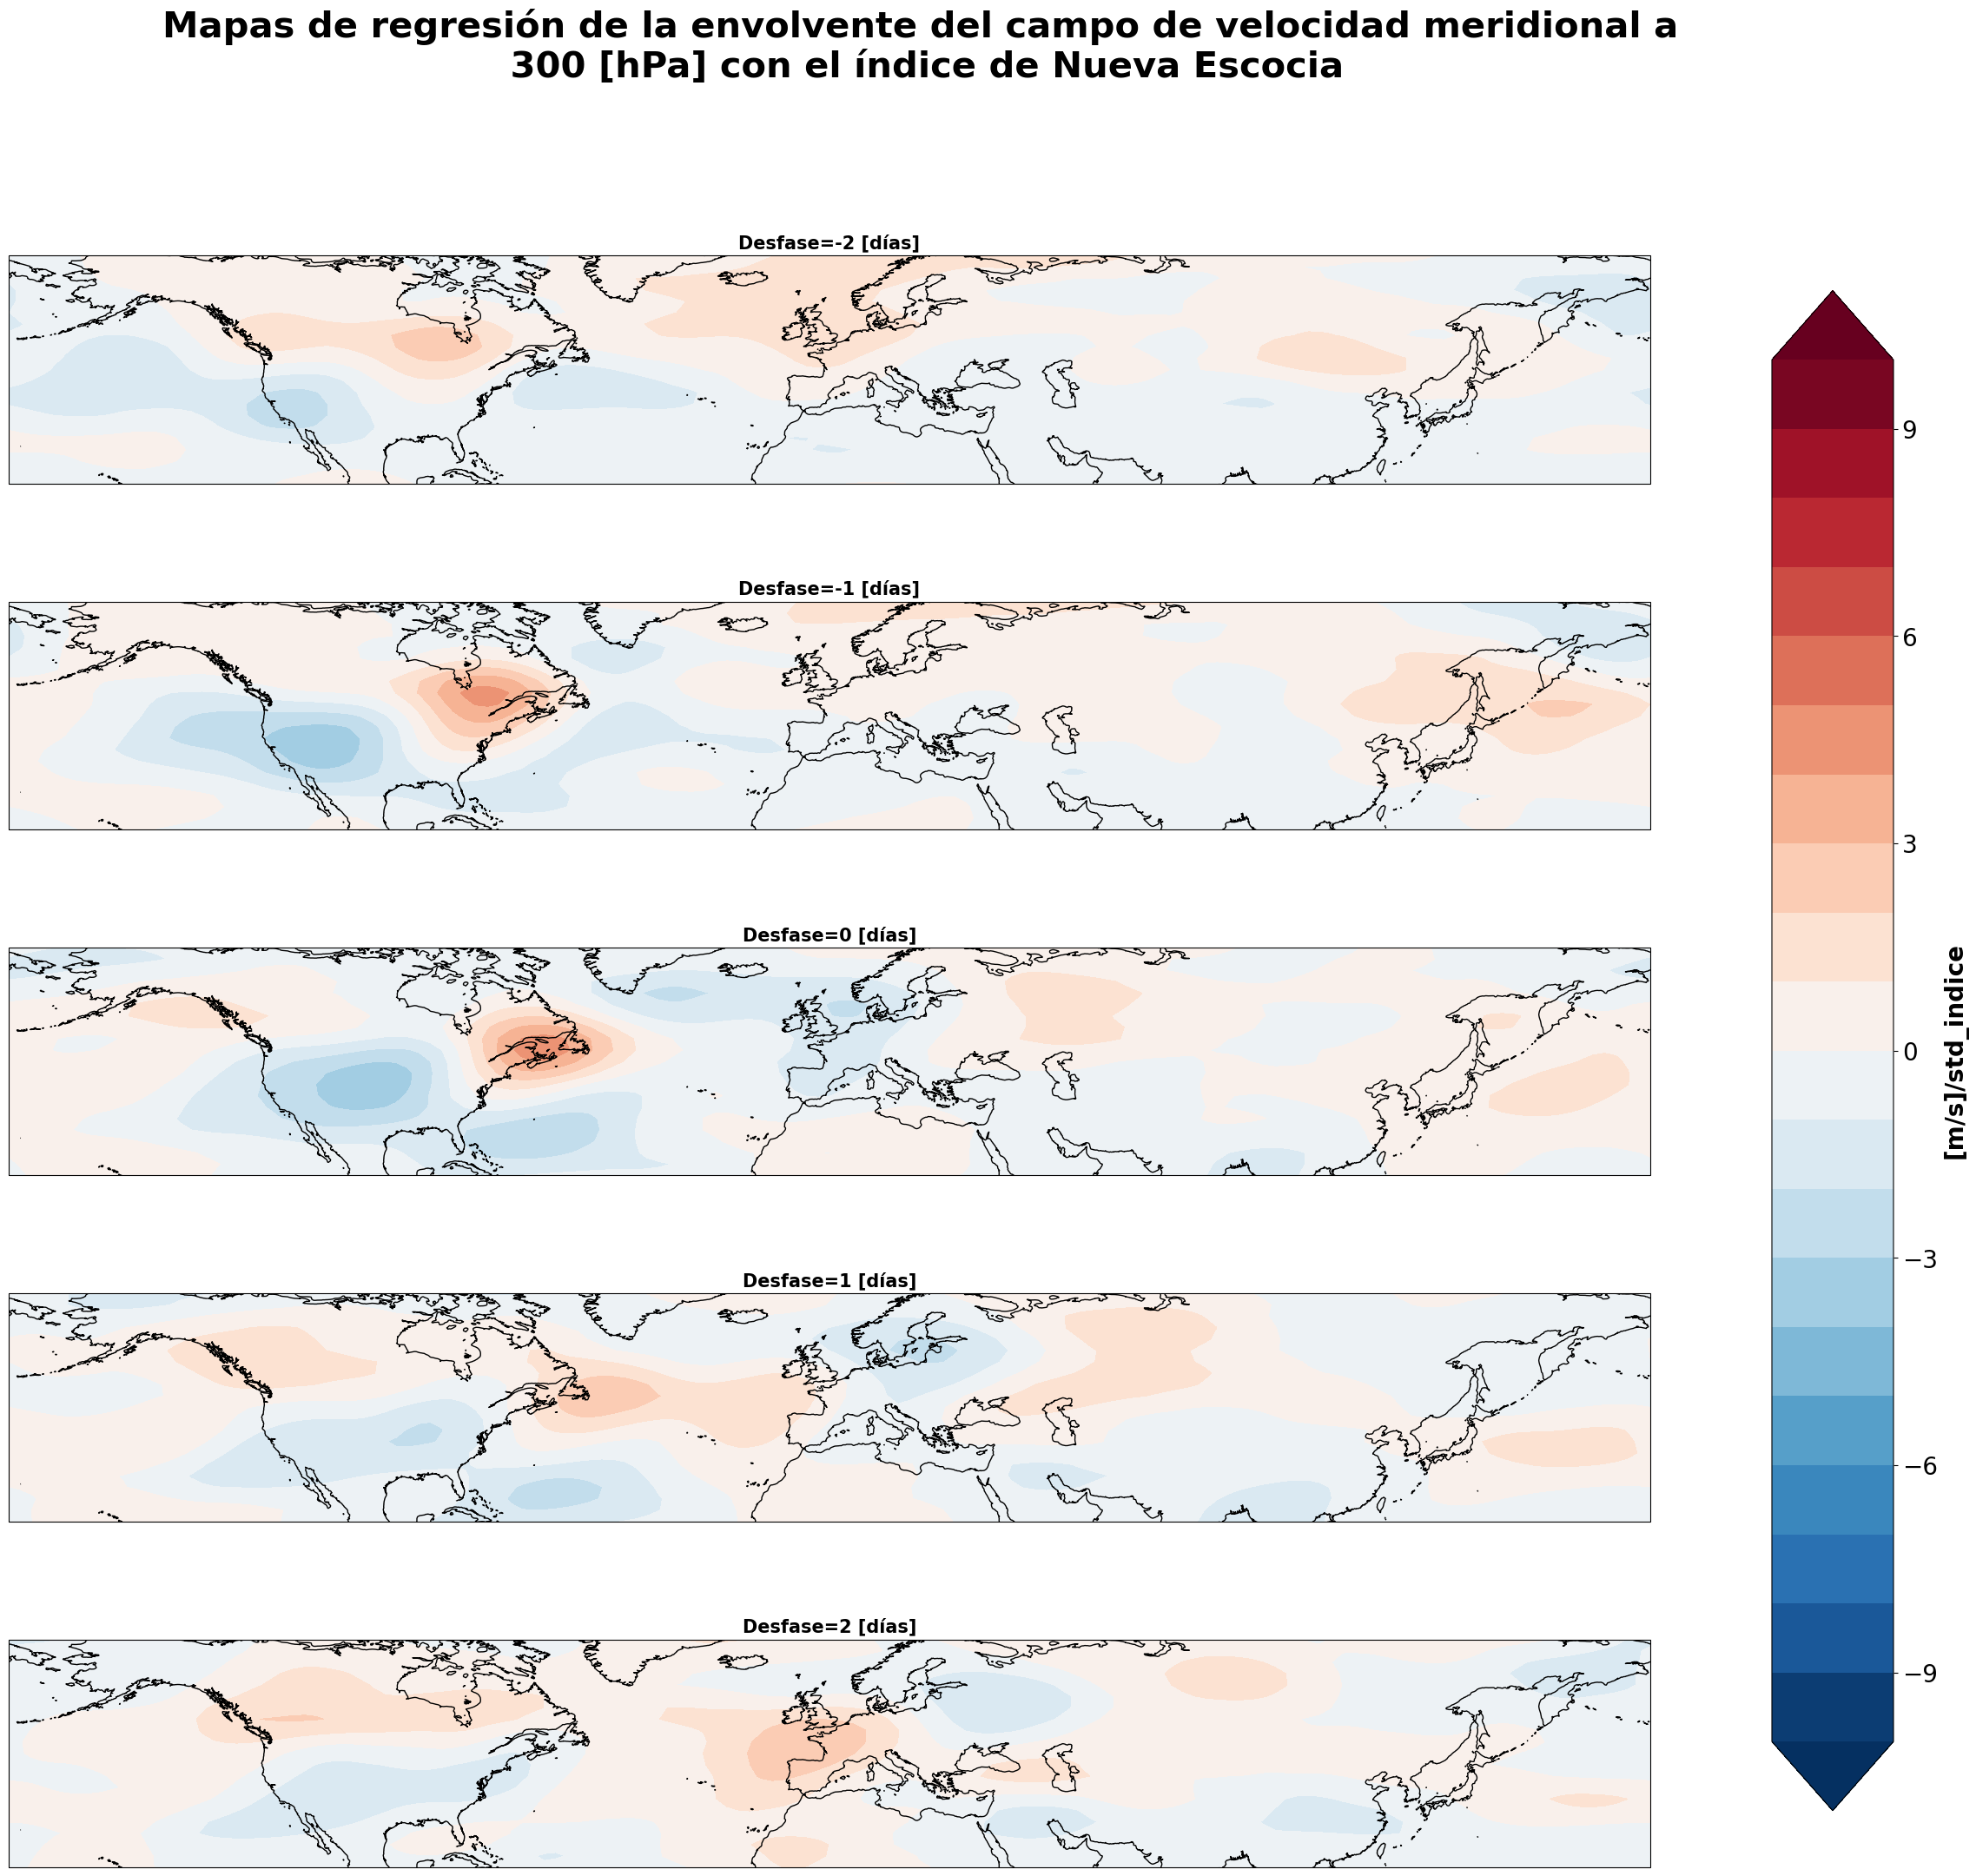

In [10]:
# calculo las regresiones para cada desfase
# pinto la figura para cada desfase
# definir un vector con los desfases temporales (lags)
lags= np.arange(-2,3,1)
fig= plt.figure(515,figsize=(28,25))
s=0
# Regresión con desfases
for l in lags: 
    # definir los límites del intervalo temporal (al hacer desfases no se pueden tomar todos los puntos de la serie)
    nmin=0-np.min([l,0])
    nmax=nt-np.max([l,0])-1
    npoints=nmax-nmin+1;   
    # calcular la regresión de la serie de anomalías estandarizadas sobre el campo
    reg=np.dot(Vf[:,nmin+l:nmax+l],punto_v_ref_std[nmin:nmax])
    reg=reg/npoints
    reg=np.reshape(reg,(nlat,nlon))
    
    # pintar figura para cada desfase
    # Necesario para que pinte bien en lon=0
    creg, clon = add_cyclic_point(reg, coord=lon)
    
    s+=1
    ax= fig.add_subplot(5,1,s, projection=ccrs.PlateCarree())    
    clevs= np.arange(-10,11,1)
    #im= ax.contourf(clon,lat,creg,cmap='RdBu_r',extend='both',transform= ccrs.PlateCarree())
    im= ax.contourf(clon,lat,creg,clevs,cmap='RdBu_r',extend='both',transform= ccrs.PlateCarree())
    ax.coastlines()
    #fig.colorbar(im,ax=ax)
    ax.set_title(label='Desfase=%i [días]' %(l),fontsize=15,weight='bold')

fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
colorbar = plt.colorbar(im, cax=cbar_ax,label='[m/s]/std_indice')
colorbar.ax.tick_params(labelsize=20)
colorbar.ax.set_ylabel('[m/s]/std_indice', fontsize=20,weight='bold')
fig.suptitle('Mapas de regresión de la envolvente del campo de velocidad meridional a\n 300 [hPa] con el índice de Nueva Escocia',fontsize=30,weight='bold')
#plt.tight_layout()
plt.savefig('Parte 1/regresion_envolvente_con_v.png')

(c) Represento el Hovmoeller de la regresión de la velocidad meridiana con su valor en el punto base en función de longitud (eje x) y desfase (eje y) para latitud y presión fijas (45N, 300hPa) y desfases comprendidos entre -7 y +7 días.

In [11]:
# selecciono el punto dado en el campo v
# hago la transpuesta para tener primero longitudes y luego tiempos
Vll= np.transpose(np.array(file.sel(lat=45, level=300).v))
Vll= Vll-np.expand_dims(Vll.mean(axis=-1),axis=-1)
Vll.shape

(144, 152)

In [12]:
# defino el vector de desfases
# hago la regresión y la guardo en una matriz para representar el Hovmoller después
REG=np.empty((nlon,15))

lags=np.arange(-7,8,1)
s=0
for l in lags: 
    nmin=0-np.min([l,0])
    nmax=nt-np.max([l,0])-1
    npoints=nmax-nmin+1;   
    reg=np.dot(Vll[:,nmin+l:nmax+l],punto_v_ref_std[nmin:nmax])
    reg=reg/npoints
    #reg=np.reshape(reg,(1,nlon))
    REG[:,s]= reg
    s+=1
    #REG=np.squeeze(np.concatenate((REG,reg),axis=1))
    
REG=np.transpose(REG)

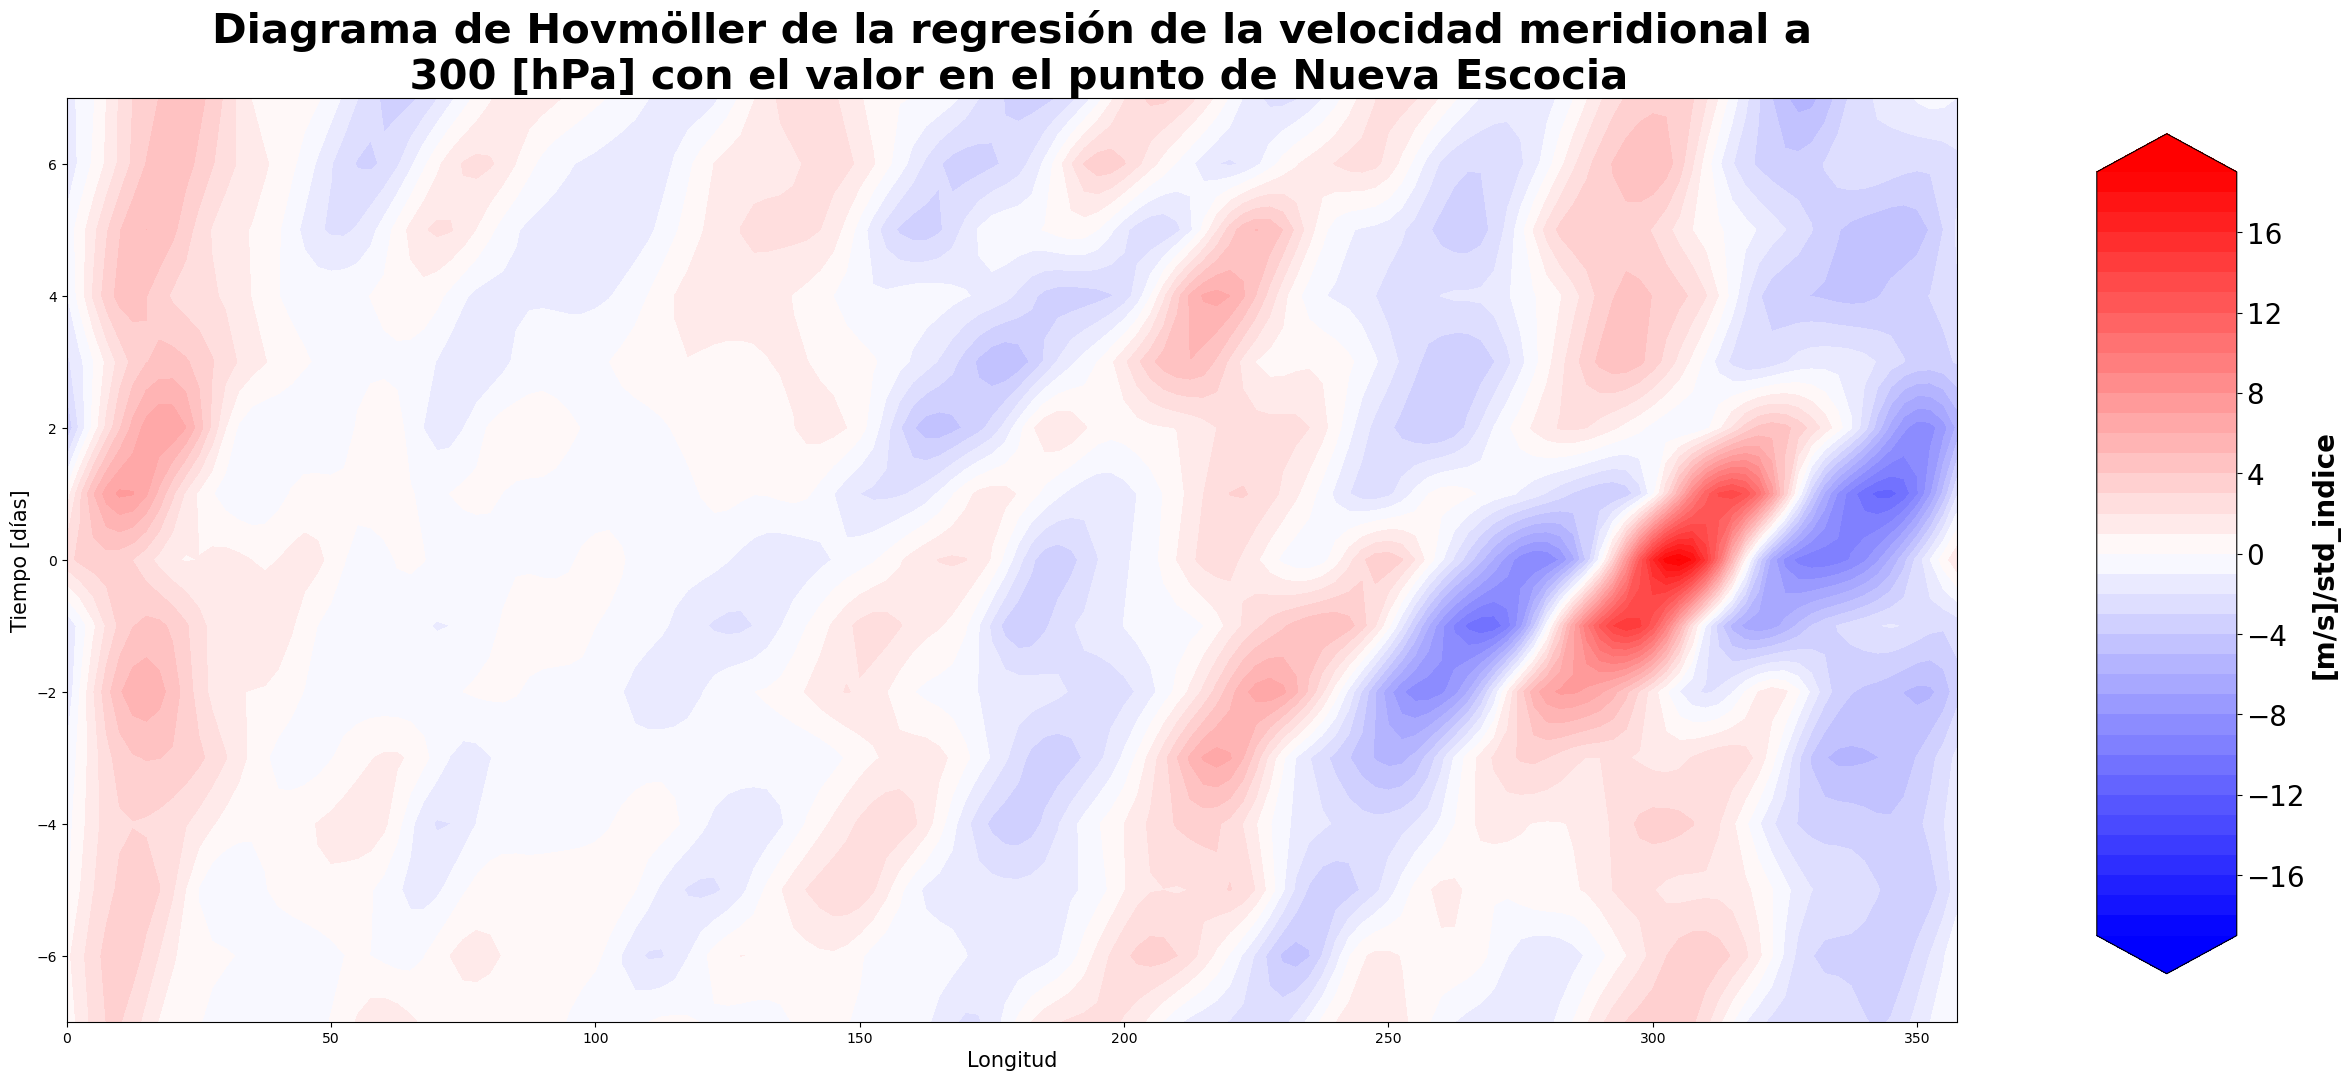

In [16]:
fig = plt.figure(figsize=(28,12)) 
ax = fig.add_subplot(1, 1, 1)
rango= np.max((np.abs(REG.min()),np.abs(REG.max())))
levels_hoevmoller= np.round(np.arange(-rango, +rango, 1),decimals=0)
im = ax.contourf(lon,lags,REG,levels_hoevmoller,cmap='bwr',extend='both')
#fig.colorbar(im,ax=ax, label='[m/s]/std_indice') #Para la barra de colores
fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
colorbar = plt.colorbar(im, cax=cbar_ax,label='[m/s]/std_indice')
colorbar.ax.tick_params(labelsize=20)
colorbar.ax.set_ylabel('[m/s]/std_indice', fontsize=20,weight='bold')
#ii = ax.contour(latT,lev/100,mediaTpast)
ax.set_xlabel('Longitud',fontsize=15)
ax.set_ylabel('Tiempo [días]',fontsize=15)
ax.set_title('Diagrama de Hovmöller de la regresión de la velocidad meridional a\n 300 [hPa] con el valor en el punto de Nueva Escocia',fontsize=30,weight='bold')
plt.savefig('Parte 1/hovmoller_velocidad.png')

### 2. Estructura vertical de las perturbaciones y transporte eddy

a) Calcular el mapa de regresión, en función de longitud y altura, de las anomalías diarias de velocidad meridiana a lo largo de la latitud 45N durante el invierno boreal extendido (Noviembre a Marzo) con las anomalías estandarizadas de velocidad meridiana en el mismo punto base del ejercicio anterior (55W, 45N, 300hPa). Representa en paneles sucesivos dicho mapa para desfases de -2, -1, 0, +1 y +2 días. 

##### ¿Son las perturbaciones más intensas en niveles altos o bajos? ¿Cómo es la inclinación observada de las líneas de fase en dirección vertical, y cuáles son las implicaciones? 
    
b) Calcular los mapas de regresión simultánea (desfase 0) de las anomalías de (i) geopotencial, (ii) temperatura, y (iii) velocidad vertical  en función de longitud y presión a 45N con las anomalías estandarizadas de velocidad meridiana en el mismo punto base de los ejercicios anteriores. Compara estos mapas con el mapa de regresión simultánea para la velocidad meridiana calculado anteriormente. Para poder compararlos mejor, limita el eje x entre 120W y 20W e incluye una rejilla. 

##### ¿Es la estructura observada consistente con la teoría? ¿Están las anomalías de  y  positiva o negativamente correlacionadas? ¿Y las de  y ? ¿Qué implicaciones tiene esto?

c)  Representa en función de latitud y presión la media zonal del producto de los mapas de regresión simultánea (desfase 0) para (i) la velocidad meridiana y la temperatura; (ii) la velocidad vertical y la temperatura; y (iii) la velocidad meridiana y la velocidad zonal. 

##### ¿En qué dirección transportan momento y calor las perturbaciones? ¿Es la estructura de estos mapas consistente con la climatología del transporte eddy? 

a) Represento el mapa de regresión en función de longitud y altura para los desfases de -2, -1, 0, +1 y +2 días.

In [204]:
# selecciono la latitud dada y reestructuro la matriz para tener tiempo, espacio
V= fil.variables['v'][:]
Vlat= np.squeeze(V[:,:,py,:])
ns2= nlon*nlev
Vlat= Vlat.reshape((nt,ns2))
Vlat= Vlat-Vlat.mean(axis=0)
Vlat= np.transpose(Vlat)

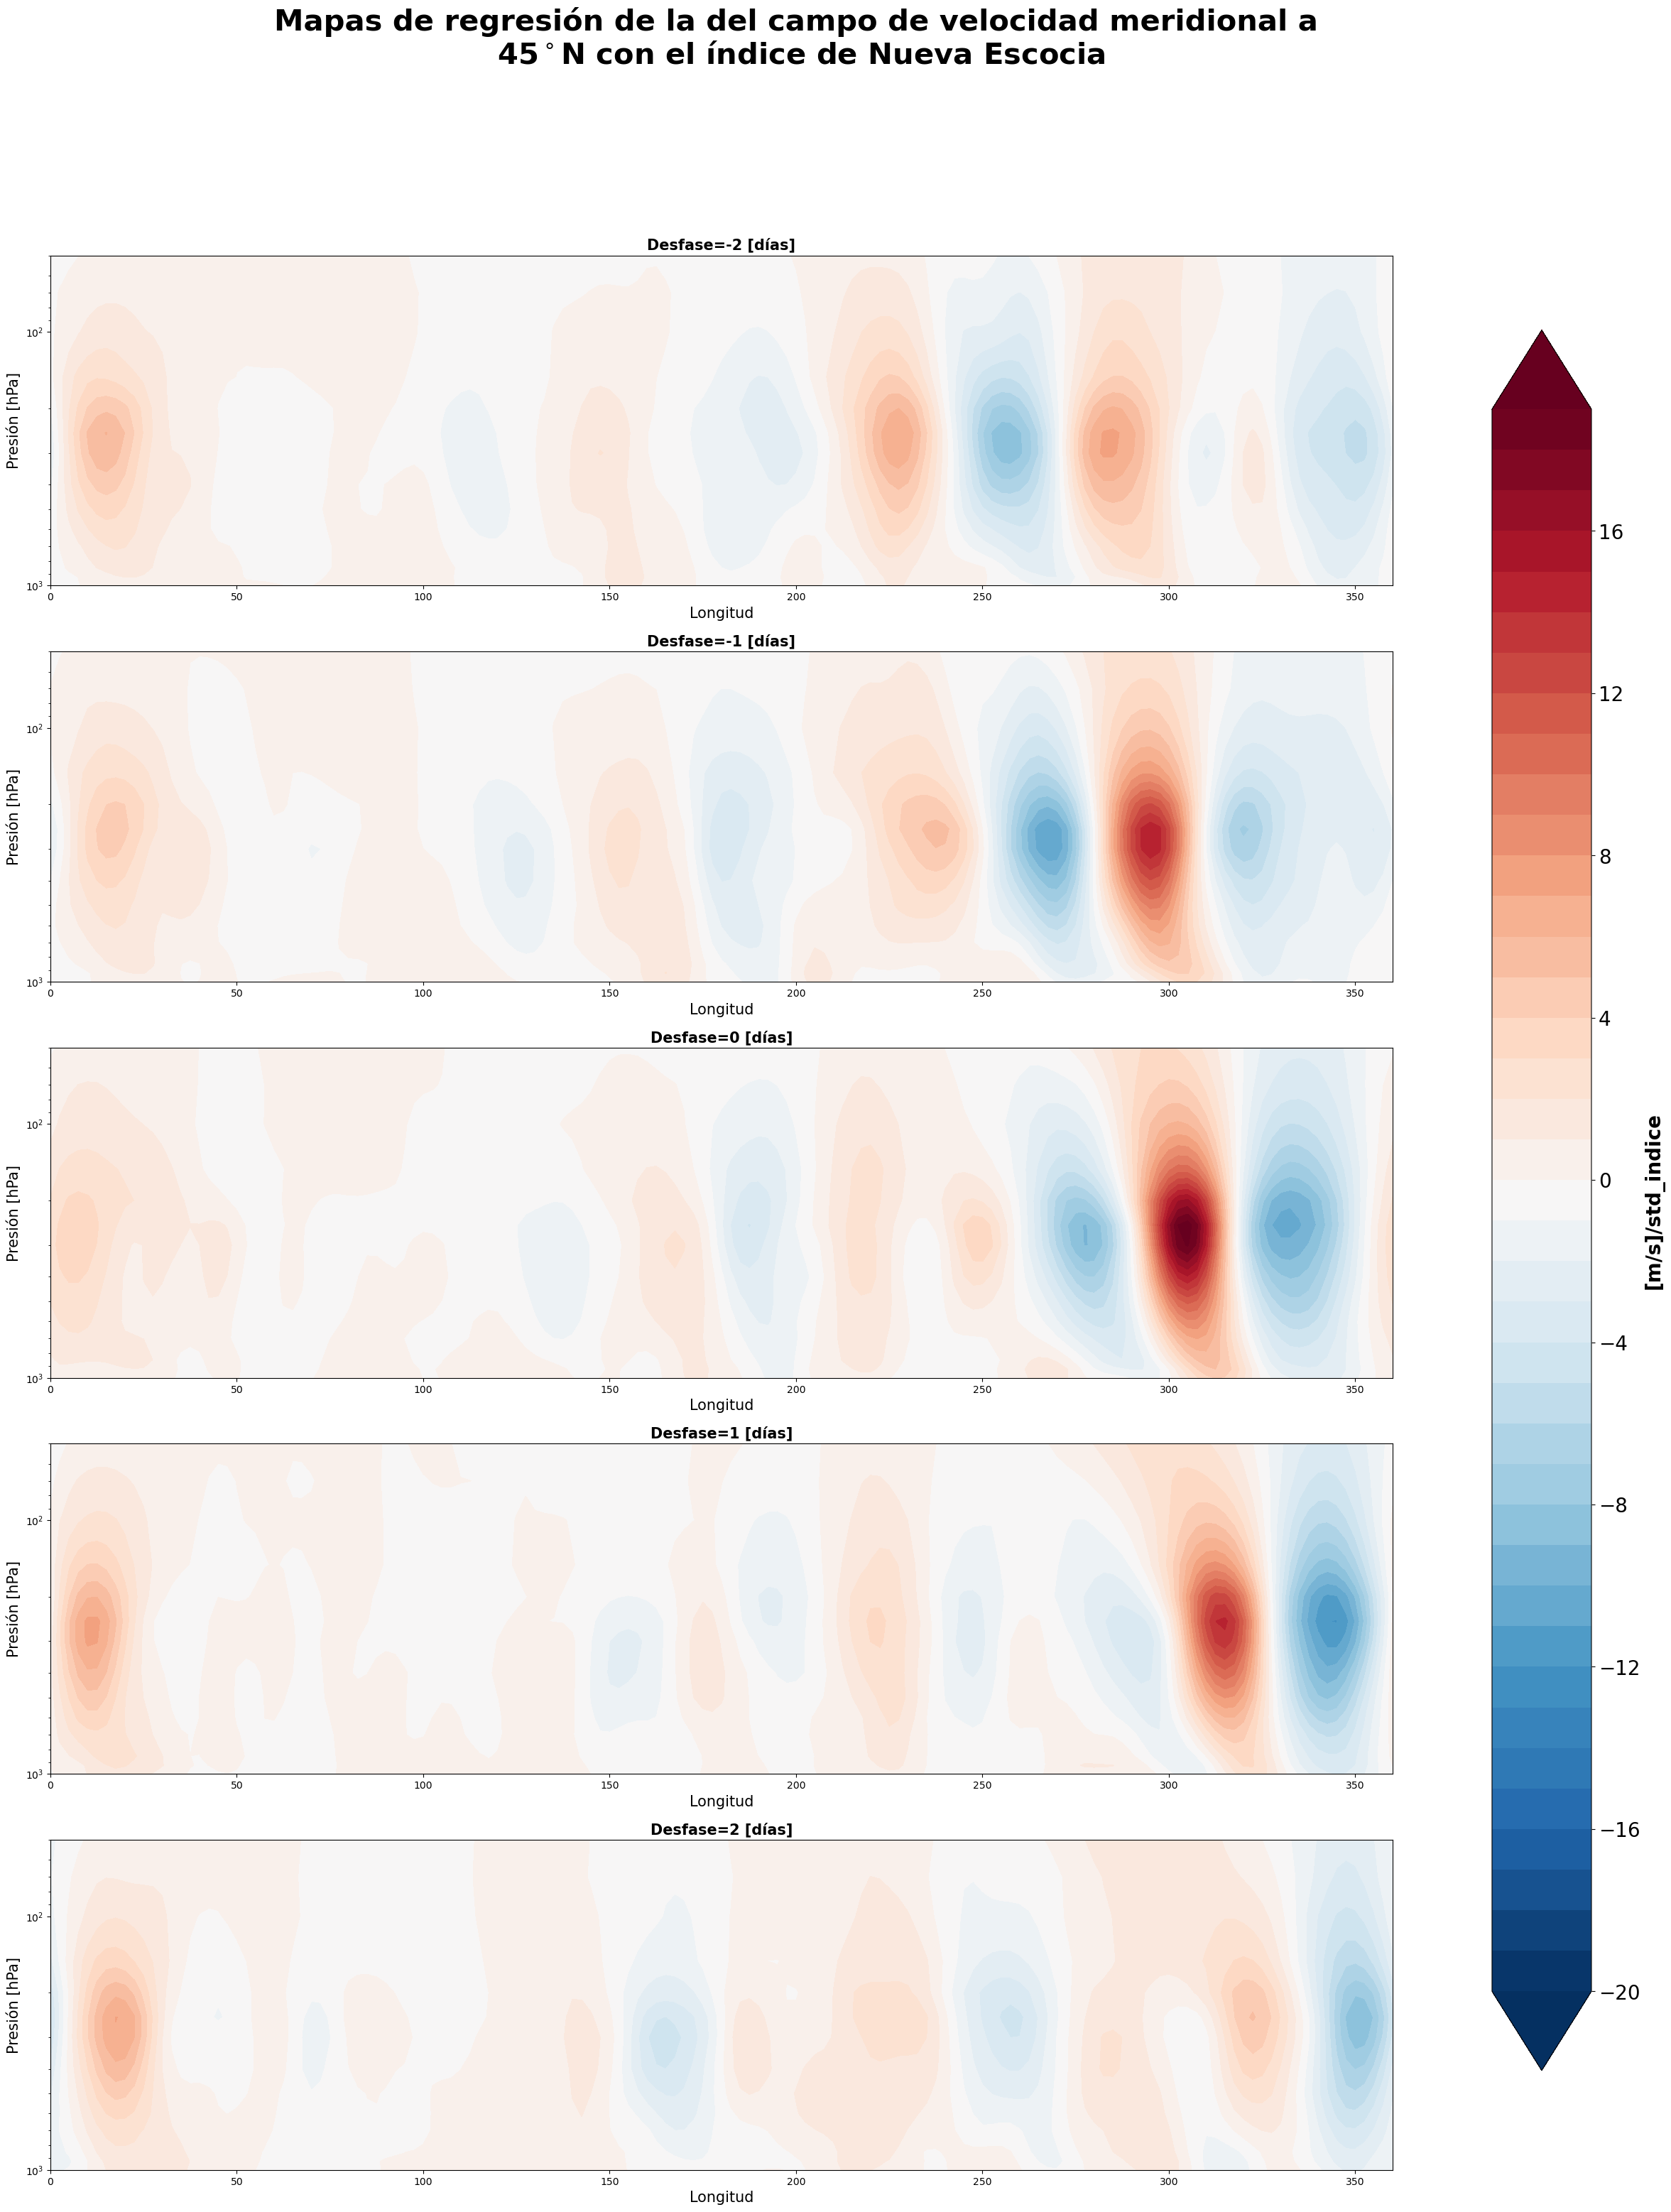

In [205]:
lags= np.arange(-2,3,1)
fig= plt.figure(515,figsize=(28,35))
s=0
# Regresión con desfases
for l in lags: 
    # definir los límites del intervalo temporal (al hacer desfases no se pueden tomar todos los puntos de la serie)
    nmin=0-np.min([l,0])
    nmax=nt-np.max([l,0])-1
    npoints=nmax-nmin+1;   
    # calcular la regresión de la serie de anomalías estandarizadas sobre el campo
    reg=np.dot(Vlat[:,nmin+l:nmax+l],punto_v_ref_std[nmin:nmax])
    reg=reg/npoints
    reg=np.reshape(reg,(nlev,nlon))
    
    # pintar figura para cada desfase
    # Necesario para que pinte bien en lon=0
    creg, clon = add_cyclic_point(reg, coord=lon)

    s+=1
    ax= fig.add_subplot(5,1,s)   
    clevs= np.arange(-20,20,1)
    im = ax.contourf(clon,levels,creg,clevs,cmap='RdBu_r',extend='both')
    ax.set_yscale('log')
    ax.invert_yaxis()
    ax.set_xlabel('Longitud',fontsize=15)
    ax.set_ylabel('Presión [hPa]',fontsize=15)
    #fig.colorbar(im,ax=ax,label='[m/s]/std_indice')
    ax.set_title(label='Desfase=%i [días]' %(l),fontsize=15,weight='bold')


fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
colorbar = plt.colorbar(im, cax=cbar_ax,label='[m/s]/std_indice')
colorbar.ax.tick_params(labelsize=20)
colorbar.ax.set_ylabel('[m/s]/std_indice', fontsize=20,weight='bold')
fig.suptitle('Mapas de regresión de la del campo de velocidad meridional a\n 45$^\circ$N con el índice de Nueva Escocia',fontsize=30,weight='bold')
#plt.tight_layout()
plt.savefig('Parte 2/regresion_con_v_a_lat45.png')


In [206]:
# defino el vector desfases 
# hago la regresión de la serie de referencia sobre esta matriz   
# represento la figura para cada valor del desfase

(b) Calculo los mapas de regresión simultánea (desfase 0) de las anomalías de (i) geopotencial, (ii) temperatura, y (iii) velocidad vertical en función de longitud y presión a 45N con las anomalías estandarizadas de velocidad meridiana en el mismo punto base de los ejercicios anteriores. Limita el eje x entre 120W y 20W e incluyo una rejilla.

(14, 144)


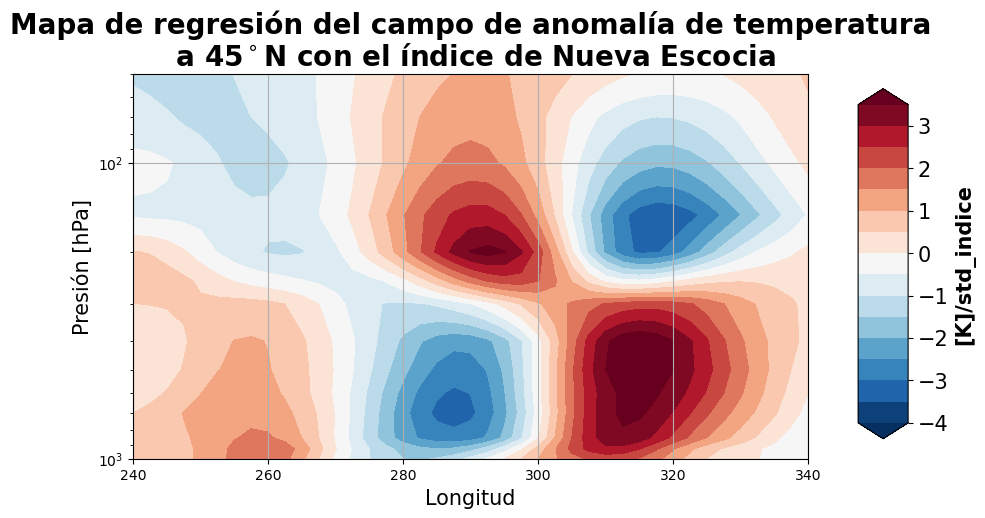

In [207]:
T= fil.variables['t'][:]
Tlat= np.squeeze(T[:,:,py,:])
Tlat= np.reshape(Tlat,(nt,ns2))
Tlat= Tlat-np.mean(Tlat,axis=0)
Tlat= np.transpose(Tlat)
Vpa= punto_v_ref_std
reg= np.dot(Tlat,Vpa)
reg= reg/nt
reg= np.reshape(reg,(nlev,nlon))
print(np.shape(reg))
creg, clon = add_cyclic_point(reg, coord=lon)


fig= plt.figure(figsize=(10,5))
ax= fig.add_subplot(1,1,1)
rango= np.max((np.abs(creg.min()),np.abs(creg.max())))
clevs= np.round(np.arange(-rango, +rango, 0.5),decimals=1)
im= ax.contourf(clon,levels,creg,clevs,cmap='RdBu_r',extend='both')
ax.set_yscale('log')
ax.invert_yaxis()
plt.xlim((240,340))
ax.grid()
ax.set_xlabel('Longitud',fontsize=15)
ax.set_ylabel('Presión [hPa]',fontsize=15)
#fig.colorbar(im,ax=ax,label='[K]/std_indice')

fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
colorbar = plt.colorbar(im, cax=cbar_ax,label='[K]/std_indice')
colorbar.ax.tick_params(labelsize=15)
colorbar.ax.set_ylabel('[K]/std_indice', fontsize=15,weight='bold')
ax.set_title(label='Mapa de regresión del campo de anomalía de temperatura\n a 45$^\circ$N con el índice de Nueva Escocia',fontsize=20,weight='bold')
#plt.tight_layout()
plt.savefig('Parte 2/regresion_con_T_a_lat45.png')

(14, 144)


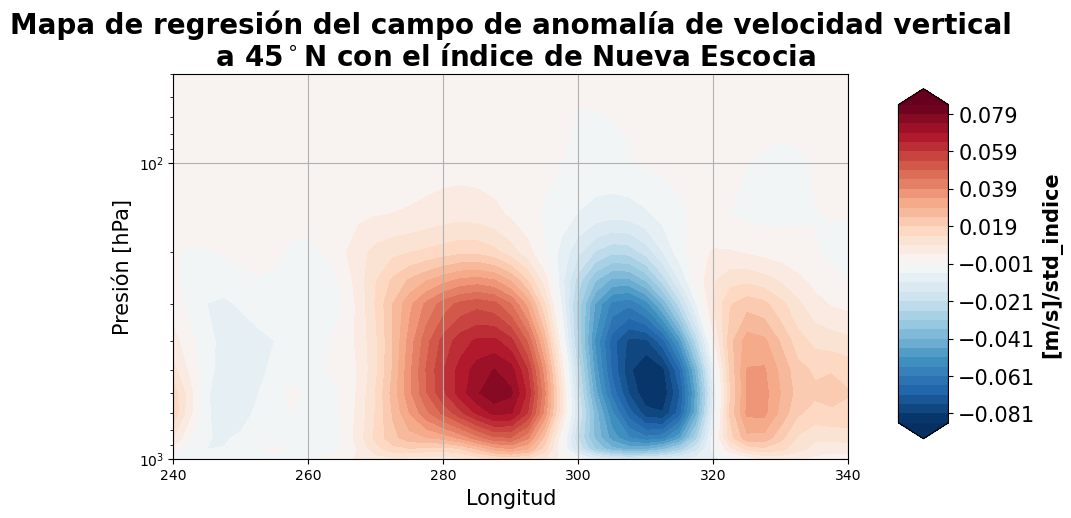

In [208]:
T= fil.variables['w'][:]
Tlat= np.squeeze(T[:,:,py,:])
Tlat= np.reshape(Tlat,(nt,ns2))
Tlat= Tlat-np.mean(Tlat,axis=0)
Tlat= np.transpose(Tlat)
Vpa= punto_v_ref_std
reg= np.dot(Tlat,Vpa)
reg= reg/nt
reg= np.reshape(reg,(nlev,nlon))
print(np.shape(reg))
creg, clon = add_cyclic_point(reg, coord=lon)


fig= plt.figure(figsize=(10,5))
ax= fig.add_subplot(1,1,1)
rango= np.max((np.abs(creg.min()),np.abs(creg.max())))
clevs= np.round(np.arange(-rango, +rango, 0.005),decimals=3)
im= ax.contourf(clon,levels,creg,clevs,cmap='RdBu_r',extend='both')
ax.set_yscale('log')
ax.invert_yaxis()
plt.xlim((240,340))
ax.grid()
ax.set_xlabel('Longitud',fontsize=15)
ax.set_ylabel('Presión [hPa]',fontsize=15)
#fig.colorbar(im,ax=ax,label='[K]/std_indice')

fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
colorbar = plt.colorbar(im, cax=cbar_ax,label='[m/s]/std_indice')
colorbar.ax.tick_params(labelsize=15)
colorbar.ax.set_ylabel('[m/s]/std_indice', fontsize=15,weight='bold')
ax.set_title(label='Mapa de regresión del campo de anomalía de velocidad vertical\n a 45$^\circ$N con el índice de Nueva Escocia',fontsize=20,weight='bold')
#plt.tight_layout()
plt.savefig('Parte 2/regresion_con_W_a_lat45.png')

(14, 144)


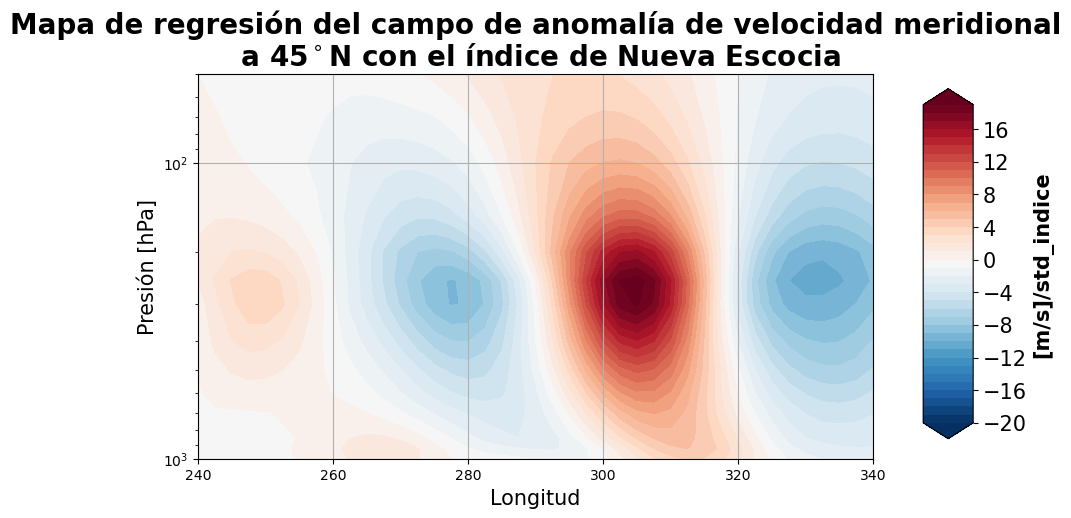

In [209]:
T= fil.variables['v'][:]
Tlat= np.squeeze(T[:,:,py,:])
Tlat= np.reshape(Tlat,(nt,ns2))
Tlat= Tlat-np.mean(Tlat,axis=0)
Tlat= np.transpose(Tlat)
Vpa= punto_v_ref_std
reg= np.dot(Tlat,Vpa)
reg= reg/nt
reg= np.reshape(reg,(nlev,nlon))
print(np.shape(reg))
creg, clon = add_cyclic_point(reg, coord=lon)


fig= plt.figure(figsize=(10,5))
ax= fig.add_subplot(1,1,1)
rango= np.max((np.abs(creg.min()),np.abs(creg.max())))
clevs= np.round(np.arange(-rango, +rango, 1),decimals=0)
im= ax.contourf(clon,levels,creg,clevs,cmap='RdBu_r',extend='both')
ax.set_yscale('log')
ax.invert_yaxis()
plt.xlim((240,340))
ax.grid()
ax.set_xlabel('Longitud',fontsize=15)
ax.set_ylabel('Presión [hPa]',fontsize=15)
#fig.colorbar(im,ax=ax,label='[K]/std_indice')

fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
colorbar = plt.colorbar(im, cax=cbar_ax,label='[m/s]/std_indice')
colorbar.ax.tick_params(labelsize=15)
colorbar.ax.set_ylabel('[m/s]/std_indice', fontsize=15,weight='bold')
ax.set_title(label='Mapa de regresión del campo de anomalía de velocidad meridional\n a 45$^\circ$N con el índice de Nueva Escocia',fontsize=20,weight='bold')
#plt.tight_layout()
plt.savefig('Parte 2/regresion_con_V_a_lat45.png')

In [210]:
fil.variables.keys()

dict_keys(['t', 'lat', 'level', 'lon', 'time', 'time_bnds', 'u', 'v', 'w', 'z'])

(14, 144)


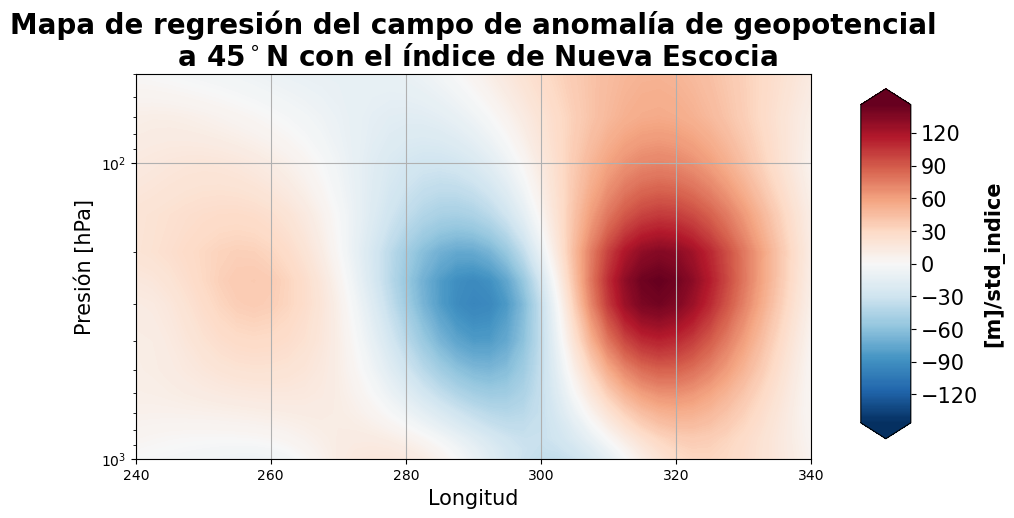

In [211]:
T= fil.variables['z'][:]
Tlat= np.squeeze(T[:,:,py,:])
Tlat= np.reshape(Tlat,(nt,ns2))
Tlat= Tlat-np.mean(Tlat,axis=0)
Tlat= np.transpose(Tlat)
Vpa= punto_v_ref_std
reg= np.dot(Tlat,Vpa)
reg= reg/nt
reg= np.reshape(reg,(nlev,nlon))
print(np.shape(reg))
creg, clon = add_cyclic_point(reg, coord=lon)


fig= plt.figure(figsize=(10,5))
ax= fig.add_subplot(1,1,1)
rango= np.max((np.abs(creg.min()),np.abs(creg.max())))
clevs= np.round(np.arange(-rango, +rango, 1),decimals=0)
im= ax.contourf(clon,levels,creg,clevs,cmap='RdBu_r',extend='both')
ax.set_yscale('log')
ax.invert_yaxis()
plt.xlim((240,340))
ax.grid()
ax.set_xlabel('Longitud',fontsize=15)
ax.set_ylabel('Presión [hPa]',fontsize=15)
#fig.colorbar(im,ax=ax,label='[K]/std_indice')

fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
colorbar = plt.colorbar(im, cax=cbar_ax,label='[m]/std_indice')
colorbar.ax.tick_params(labelsize=15)
colorbar.ax.set_ylabel('[m]/std_indice', fontsize=15,weight='bold')
ax.set_title(label='Mapa de regresión del campo de anomalía de geopotencial\n a 45$^\circ$N con el índice de Nueva Escocia',fontsize=20,weight='bold')
#plt.tight_layout()
plt.savefig('Parte 2/regresion_con_Z_a_lat45.png')

In [212]:
# abro las variables pedidas
# selecciono la latitud dada en los campos y reestructuro para tener matrices de tamaño tiempo, espacio

In [213]:
# calulo la regresión de la serie de referencia sobre la matriz del geopotencial
# represento la figura

In [214]:
# calulo la regresión de la serie de referencia sobre la matriz de la temperatura
# represento la figura

In [215]:
# calulo la regresión de la serie de referencia sobre la matriz de la velocidad vertical (omega)
# represento la figura

In [216]:
# calulo la regresión de la serie de referencia sobre la matriz de la velocidad meridional
# represento la figura

(c) Represento en función de latitud y presión la media zonal del producto de las regresiones de (i) la velocidad meridiana y la temperatura (flujo eddy meridional de calor); (ii) la velocidad vertical y la temperatura (flujo eddy vertical de calor); y (iii) la velocidad meridiana y la velocidad zonal (flujo eddy meridional de momento). 

In [217]:
# regresión de la serie de referencia sobre el campo de v
V = allvars['v'][:]
ns3 = nlev * nlat * nlon
V = V.reshape((nt, ns3))
V = np.transpose(V)
regV = np.dot(V,Vpa)
regV = regV / nt
regV = np.reshape(regV,(nlev,nlat,nlon))

# regresión de la serie de referencia sobre el campo de T
T = allvars['t'][:]
T = T.reshape((nt,ns3))
T = np.transpose(T)
regT = np.dot(T,Vpa)
regT = regT / nt
regT = np.reshape(regT,(nlev,nlat,nlon))
regT.shape

(14, 21, 144)

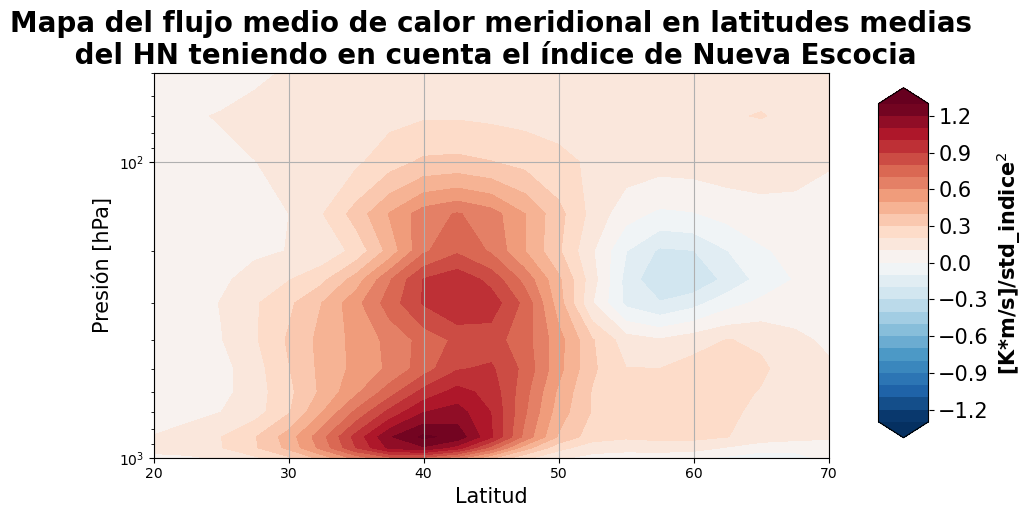

In [218]:
regVT= np.mean(regV*regT,axis=2)
regVT= np.reshape(regVT,(nlev,nlat))


fig= plt.figure(figsize=(10,5))
ax= fig.add_subplot(1,1,1)
rango= np.max((np.abs(regVT.min()),np.abs(regVT.max())))
clevs= np.round(np.arange(-rango, +rango, 0.1),decimals=1)
im= ax.contourf(lat,levels,regVT,clevs,cmap='RdBu_r',extend='both')
ax.set_yscale('log')
ax.invert_yaxis()
ax.grid()
ax.set_xlabel('Latitud',fontsize=15)
ax.set_ylabel('Presión [hPa]',fontsize=15)
#fig.colorbar(im,ax=ax,label='[K]/std_indice')

fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
colorbar = plt.colorbar(im, cax=cbar_ax,label='[K*m/s]/std_indice$^2$')
colorbar.ax.tick_params(labelsize=15)
colorbar.ax.set_ylabel('[K*m/s]/std_indice$^2$', fontsize=15,weight='bold')
ax.set_title(label='Mapa del flujo medio de calor meridional en latitudes medias\n del HN teniendo en cuenta el índice de Nueva Escocia',fontsize=20,weight='bold')
#plt.tight_layout()
plt.savefig('Parte 2/flujo_de_calor.png')

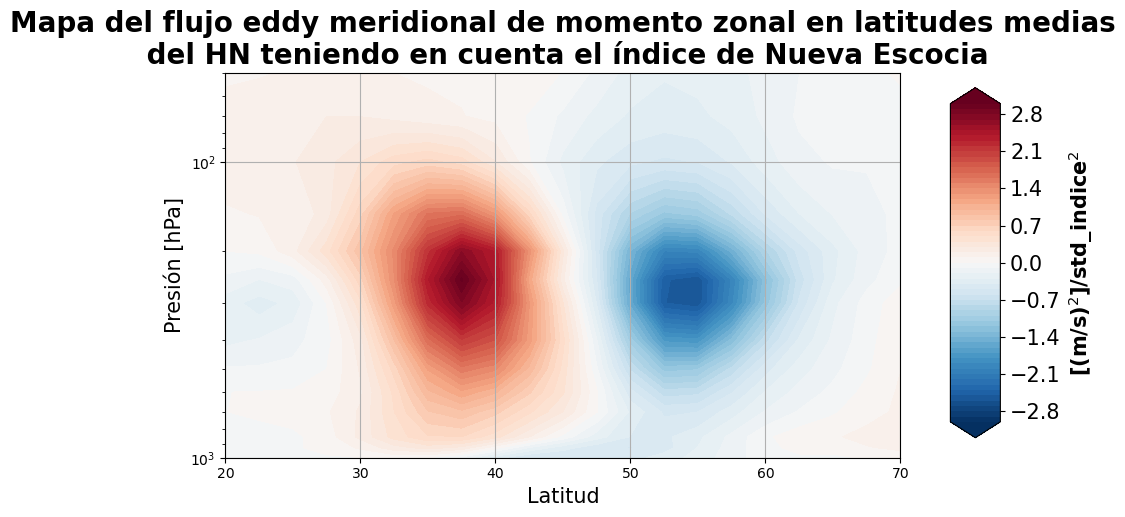

In [219]:
# regresión de la serie de referencia sobre el campo de v
V = allvars['v'][:]
ns3 = nlev * nlat * nlon
V = V.reshape((nt, ns3))
V = np.transpose(V)
regV = np.dot(V,Vpa)
regV = regV / nt
regV = np.reshape(regV,(nlev,nlat,nlon))

# regresión de la serie de referencia sobre el campo de u
T = allvars['u'][:]
T = T.reshape((nt,ns3))
T = np.transpose(T)
regT = np.dot(T,Vpa)
regT = regT / nt
regT = np.reshape(regT,(nlev,nlat,nlon))
regT.shape

regVT= np.mean(regV*regT,axis=2)
regVT= np.reshape(regVT,(nlev,nlat))


fig= plt.figure(figsize=(10,5))
ax= fig.add_subplot(1,1,1)
rango= np.max((np.abs(regVT.min()),np.abs(regVT.max())))
clevs= np.round(np.arange(-rango, +rango, 0.1),decimals=1)
im= ax.contourf(lat,levels,regVT,clevs,cmap='RdBu_r',extend='both')
ax.set_yscale('log')
ax.invert_yaxis()
ax.grid()
ax.set_xlabel('Latitud',fontsize=15)
ax.set_ylabel('Presión [hPa]',fontsize=15)
#fig.colorbar(im,ax=ax,label='[K]/std_indice')

fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
colorbar = plt.colorbar(im, cax=cbar_ax,label='[(m/s)$^2$]/std_indice$^2$')
colorbar.ax.tick_params(labelsize=15)
colorbar.ax.set_ylabel('[(m/s)$^2$]/std_indice$^2$', fontsize=15,weight='bold')
ax.set_title(label='Mapa del flujo eddy meridional de momento zonal en latitudes medias\n del HN teniendo en cuenta el índice de Nueva Escocia',fontsize=20,weight='bold')
#plt.tight_layout()
plt.savefig('Parte 2/flujo_de_momento.png')

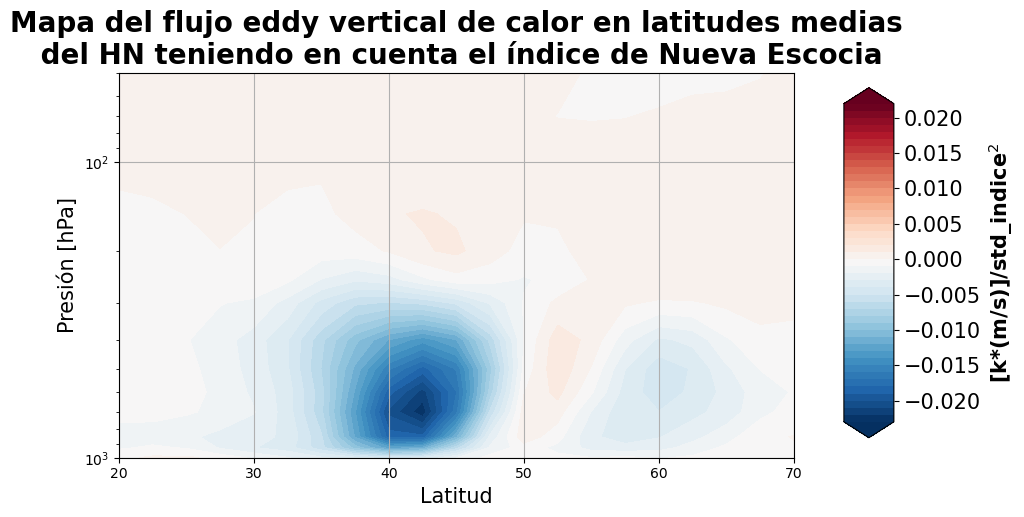

: 

In [220]:
# regresión de la serie de referencia sobre el campo de W
V = allvars['w'][:]
ns3 = nlev * nlat * nlon
V = V.reshape((nt, ns3))
V = np.transpose(V)
regV = np.dot(V,Vpa)
regV = regV / nt
regV = np.reshape(regV,(nlev,nlat,nlon))

# regresión de la serie de referencia sobre el campo de T
T = allvars['t'][:]
T = T.reshape((nt,ns3))
T = np.transpose(T)
regT = np.dot(T,Vpa)
regT = regT / nt
regT = np.reshape(regT,(nlev,nlat,nlon))
regT.shape

regVT= np.mean(regV*regT,axis=2)
regVT= np.reshape(regVT,(nlev,nlat))


fig= plt.figure(figsize=(10,5))
ax= fig.add_subplot(1,1,1)
rango= np.max((np.abs(regVT.min()),np.abs(regVT.max())))
clevs= np.round(np.arange(-rango, +rango, 0.001),decimals=3)
im= ax.contourf(lat,levels,regVT,clevs,cmap='RdBu_r',extend='both')
ax.set_yscale('log')
ax.invert_yaxis()
ax.grid()
ax.set_xlabel('Latitud',fontsize=15)
ax.set_ylabel('Presión [hPa]',fontsize=15)
#fig.colorbar(im,ax=ax,label='[K]/std_indice')

fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
colorbar = plt.colorbar(im, cax=cbar_ax,label='[k*(m/s)]/std_indice$^2$')
colorbar.ax.tick_params(labelsize=15)
colorbar.ax.set_ylabel('[k*(m/s)]/std_indice$^2$', fontsize=15,weight='bold')
ax.set_title(label='Mapa del flujo eddy vertical de calor en latitudes medias\n del HN teniendo en cuenta el índice de Nueva Escocia',fontsize=20,weight='bold')
#plt.tight_layout()
plt.savefig('Parte 2/flujo_de_vertical_de_calor.png')